# 2D Strang-Splitting

Include some important libraries.

In [247]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import pyfftw
import time

import utils
import schemes
import checker

%matplotlib inline

Code to test for 2nd order convergence in time of Strang-Splitting + Adam-Bashforth.

In [250]:
# parameters for numerics
seed = np.random.randint(1)
seed = 555

dt = 0.001
Nx = 100
L = 2.*np.pi

eps = 0.06
sigma = 0.5
m = 0.33

# number of iterations
it = 200000
it += 1

# intervals levels to capture snapshot of morphology.
lv = 1000

# define pyfftw wisdom
wisdom = None

In [251]:
tic = time.time()
us, avgConc, energy, wisdom = schemes.strangSplitting(Nx,L,dt,it,eps,sigma,m,seed,wisdom,lv)
u = us[...,-1]
toc = time.time()

print("time taken: %.2f" %(toc-tic))

time taken: 1160.52


Run checks on energy and average concentration vs time.
Expectations: energy decreases, and average concentration remains within bound to $m$.

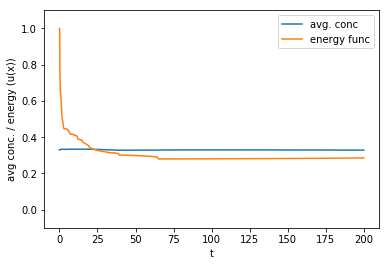

In [258]:
# check if energy decreases (within tolerance, 1e-3) through the experiment.
checker.energyCheck(energy)

# check if avg. conc. change stays within tolerance, 5e-3.
checker.concCheck(avgConc,m)

# plot energy and avg. conc.
t = np.arange(0,it/10+1)*dt*10

fig2 = plt.figure()
ax = plt.gca()
ax.set_ylim([-.1,1.1])
plt.xlabel('t')
plt.ylabel('avg conc. / energy (u(x))')
plt.plot(t,avgConc)
plt.plot(t,energy)
plt.legend(['avg. conc','energy func'])
plt.show()

Process the results of the order parameter arrays from above. Here, the error $\texttt{err}$ is calculated as the $l_2$- or Frobenius norm of the order parameter arrays $u$. The 'exact' solution is taken to be $u$ after $2\cdot10^5$ iterations. Plots are 
1. $\log(\text{err})$ vs $\log(\text{iterations})$ for an interval given in $\texttt{low}$ and $\texttt{high}$.
2. $\log(\text{err})$ vs $\log(\text{iterations})$ over the entire simulation.
3. $\text{err}$ vs $\text{iterations}$ over the entire simulation.

gradient of best-fit is -0.716713.


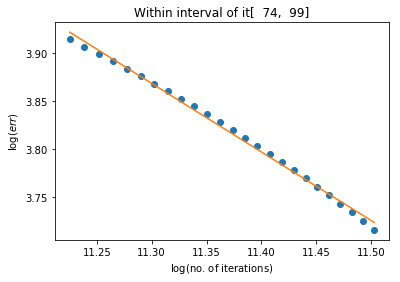

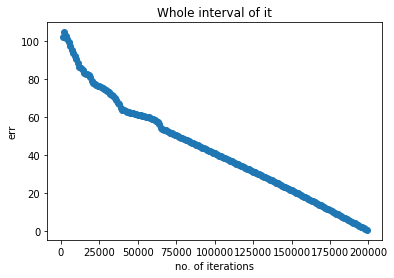

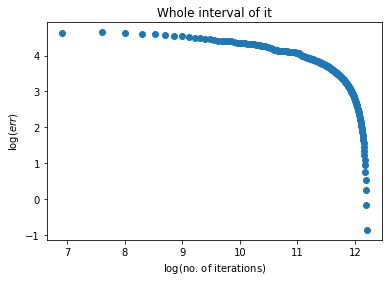

In [263]:
# define iterations where snapshot of the morphology was taken.
its = np.array(range(0,it,lv))
its = its[1:]

# define range of subinterval.
lowN = 75000
highN = 100000

# get path of arrays.
imgDir = 'imgs'
tag = ',strangFFTW_2D'
path = utils.getPath(Nx,L,dt,it,eps,sigma,m,seed,lv,imgDir,tag)

# initialize array to store all order parameter arrays.
us = np.zeros((Nx,Nx,len(its)))
j = 0
for itx in its:
    # load the order parameter arrays.
    us[...,j] = np.loadtxt(path+'/it='+str(itx)+'.txt')
    j += 1
    
# get the 'exact solution'
uSol = np.loadtxt(path+'/it='+str(its[-1])+'.txt')
uSol = uSol.reshape(Nx,Nx,1)

# find difference between the order parameter at each iteration and the 'exact solution'.
us = us[...,:-1] - uSol
its = its[:-1]

# l2-norm calculations.
#errs = np.sum(np.sum(abs(us)**2,axis=0),axis=0)**0.5
errs = np.linalg.norm(us,axis=(0,1))

# get a subinterval of all iterations.
low = np.where(its == lowN)[0][0]
high = np.where(its == highN)[0][0]
itsInt = its[low:high]
errsInt = errs[low:high]

# best-fit line for error.
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(itsInt),np.log(errsInt))
line = slope*np.log(itsInt)+intercept

print("gradient of best-fit is %.6f." %(slope))

# plots.
fig3 = plt.figure()
plt.plot(np.log(itsInt),np.log(errsInt),'o')
plt.plot(np.log(itsInt), line,'-')
plt.xlabel(r'$\log($no. of iterations$)$')
plt.ylabel(r'$\log(err)$')
plt.title('Within interval of it[%4i,%4i]' %(low,high))
plt.show()

fig4 = plt.figure()
plt.plot(its,errs,'o')
plt.xlabel(r'no. of iterations')
plt.ylabel(r'err')
plt.title('Whole interval of it')
plt.show()

fig5 = plt.figure()
plt.plot(np.log(its),np.log(errs),'o')
plt.xlabel(r'$\log($no. of iterations$)$')
plt.ylabel(r'$\log(err)$')
plt.title('Whole interval of it')
plt.show()